In [1]:
# Conor Edgecumbe Ogletree Tech Challenge ver1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import statistics

from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.preprocessing import OrdinalEncoder
from nltk.sentiment.vader import SentimentIntensityAnalyzer

%matplotlib inline

In [2]:
df = pd.read_csv('DATA/technical_challenge_v1.csv')

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cedge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cedge\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\cedge\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\cedge\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Cursory Analysis and Cleaning

In [4]:
print(df.shape)
print(df.columns)

(1900, 4)
Index(['File', 'Case', 'Case_Text', 'row'], dtype='object')


In [5]:
df.info()
print(df.isna().sum())
print(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   File       1900 non-null   object
 1   Case       1900 non-null   object
 2   Case_Text  1882 non-null   object
 3   row        1900 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 59.5+ KB
File          0
Case          0
Case_Text    18
row           0
dtype: int64
File         object
Case         object
Case_Text    object
row           int64
dtype: object


In [6]:
# moving null entries to separate dataframe
df_clean = df.dropna()
df_na = df[~df.index.isin(df_clean.index)]

## Techincal Challenge Tasks

In [7]:
# 1. Remove Extraneous Movie Reviews
df_movie = []
reConNum1 = r'(\[.*\d+.*\])'
reConNum2 = r'(\(.*\d+.*\))'
drop = []

# extract movie reviews
for index,row in df_clean.iterrows():
    mo1 = re.search(reConNum1,row['Case_Text'])
    mo2 = re.search(reConNum2,row['Case_Text'])
    moS = re.search(r'\s',row['Case_Text'])
    if (mo1 == None and mo2 == None):
        if moS != None:
            df_movie.append(row)
            drop.append(index)
            
df_clean = df_clean.drop(drop)
df_clean = df_clean.reset_index(drop=True)

In [8]:
# save csv
pd.Series(df_movie).to_csv('movie.csv')

In [9]:
# 2. Remove the Row Column
df_clean = df_clean.drop('row',axis=1)

In [10]:
# 3. Create column Case_Year
case_year = []
re_year = r'\d{4}'
for index,row in df_clean.iterrows():
    years = re.findall(re_year,row['Case'])
    if len(years) > 0:
        case_year.append(int(min(years)))
    else:
        case_year.append(None)    # some cases are missing their year

df_clean['Case_Year'] = case_year

In [11]:
# 4a. Clean up Case_Text - extra newlines
df_clean = df_clean.reset_index(drop=True)
nl_re = r'\n\s*\n'

for index,row in df_clean.iterrows():
    df_clean.loc[index,'Case_Text'] = re.sub(nl_re, '\n\n', row['Case_Text'])

In [12]:
# 4b. Clean up Case_Text - integer paragraph markers
para_re1 = r'\n\s*\d{1,3}(\s|\.\s)'
para_re2 = r'^\d{1,3}(\s|\.\s)'
for index,row in df_clean.iterrows():
    df_clean.loc[index,'Case_Text'] = re.sub(para_re1,'\n\n',row['Case_Text'])
for index,row in df_clean.iterrows():    # after changing conda env, for some reason does not process both subs together, separate loops fix..   
    df_clean.loc[index,'Case_Text'] = re.sub(para_re2,'',row['Case_Text'])

In [13]:
# 5. Create column Case_Reference
case_references = []
for index,row in df_clean.iterrows():
    refs = []
    txt = row['Case_Text']
    refs = [sentence + '.' for sentence in txt.split('.') if 'Case' in sentence]
    case_references.append(refs)
df_clean['Case_Reference'] = case_references

In [14]:
# 6. Save data as .json and .csv
json_out = df_clean.to_json(orient='records')
with open('final_data.json','w') as outfile:
    outfile.write(json_out)
df_clean.to_csv('final_data.csv')

In [15]:
# 7.  Extract PEOPLE, LOCATION, DATE entities
# see extraction.txt

In [16]:
# 8. Sentiment Analysis
sia = SentimentIntensityAnalyzer()
sent_scores = []
for index,row in df_clean.iterrows():
    txt = row['Case_Text']
    sent = sia.polarity_scores(txt)
    sent_scores.append(sent)
df_clean['sentiment'] = sent_scores

In [17]:
# 9. Machine Learning
# Concerning data augmentation: I was unsure how to augment the data for unseen-years that were not part of the prediction task (2009-2021)
# I did not do any data augmentation, rather I transformed the data by averaging over 5 year spans in an attempt to reduce noise and find a decent fit to averaged trend
# Just did a simple regression, extrapolated the 2nd order polynomial fit to unseen years 2009-2027

In [18]:
# data preparation
df_clean = df_clean.dropna()
df = df_clean[df_clean.Case_Year >= 1970]    # remove years 1969 and earlier

In [19]:
yr_ct = df['Case_Year'].value_counts()
case_count = yr_ct.values
years = np.array(yr_ct.axes)[0]
yearly_cases = list(map(lambda x,y:(x,y),years,case_count))
yearly_cases.sort()
years_sort = np.array([x[0] for x in yearly_cases])
num_cases_sort = np.array([x[1] for x in yearly_cases])

In [20]:
# Experimenting with a linear SVR for visualization
X_test = [2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]
svr = SVR(kernel='linear')
svr.fit(years_sort.reshape(-1,1),num_cases_sort)
y_hat = svr.predict(np.array(X_test).reshape(-1,1))

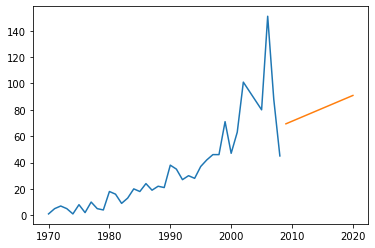

In [21]:
# Very noisy past 2000
plt.plot(years_sort,num_cases_sort)
plt.plot(np.array(X_test).reshape(-1,1),y_hat)
plt.show()

In [22]:
# average cases every 5 years
n=5
cases_5avg = [sum(num_cases_sort[i:i+n])//n for i in range(0,len(num_cases_sort),n)]
years_5 = years_sort[::5]

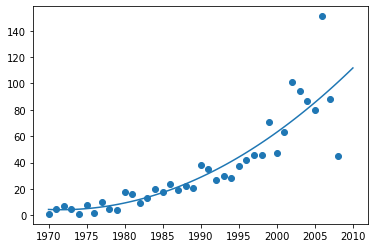

0.7866006106589798


In [23]:
# polynomial fit to original data
mymodel = np.poly1d(np.polyfit(years_sort, num_cases_sort, 2))
myline = np.linspace(1970, 2010, 100)

plt.scatter(years_sort, num_cases_sort)
plt.plot(myline, mymodel(myline))
plt.show()
print(r2_score(num_cases_sort, mymodel(years_sort)))

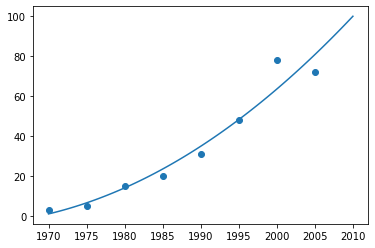

0.9459919566749599


In [24]:
# polynomial fit to avg
x = years_5
y = cases_5avg
mymodel = np.poly1d(np.polyfit(x, y, 2))
myline = np.linspace(1970, 2010, 100)

plt.scatter(x, y)
plt.plot(myline, mymodel(myline))
plt.show()
print(r2_score(y, mymodel(x)))

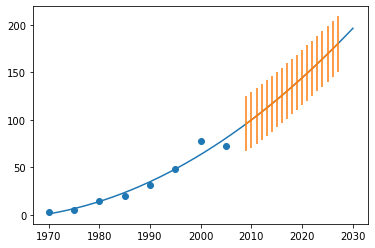

In [25]:
# predictions
X_test = []
for i in range(0,19):
    X_test.append(2009+i)
y_hat = mymodel(X_test)

myline = np.linspace(1970, 2030, 200)
plt.scatter(x, y)
plt.plot(myline, mymodel(myline))
plt.errorbar(X_test,y_hat,yerr = statistics.stdev(y))
plt.show()